# Week 3: Introduction to RasterIO

Individual learning outcomes: After this week, all students should be able to access raster dataset attributes and georeferencing, and be able to read in an image, access its metadata and use basic functionality of the RasterIO library. 

All students should also be able to  login to the Copernicus Data Hub, search manually for Sentinel-2 images and download images.

First, we need to connect to our Google Drive from Colab.

In [1]:
# Load the Drive helper and mount your Google Drive as a drive in the virtual machine
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now let us import all necessary libraries.
We may need to install the RasterIO library before we can import it, as it is not part of Colab's default libraries. We can do this with the !pip install command.

In [2]:
# Adapted from https://www.hatarilabs.com/ih-en/sentinel2-images-explotarion-and-processing-with-python-and-rasterio

# install some libraries that are not on Colab by default
!pip install rasterio
!pip install geopandas
!pip install rasterstats
!pip install sentinelsat

#import required libraries
import rasterio
from rasterio import plot
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import numpy as np
import sys

# import the pygge library of functions for this module
# make sure that this path points to the location of the pygge module on your Google Drive
libdir = '/content/drive/MyDrive/practicals21-22' # this is where pygge.py needs to be saved
if libdir not in sys.path:
    sys.path.append(libdir)
# import the pygge module
import pygge

%matplotlib inline

Make sure before running the next cell, you have uploaded the Sentinel-2 image to your Google Drive. Check in the directory structure on the left hand side of Colab whether it is there. You may need to adapt the file path and file names if you are using a different Sentinel-2 image.

In [5]:
#open bands as separate single-band raster
imagePath = '/content/drive/MyDrive/practicals21-22/S2A_MSIL2A_20180507T110621_N0207_R137_T30UXD_20180507T131836.SAFE/GRANULE/L2A_T30UXD_A015006_20180507T110835/IMG_DATA/R10m/'

band2 = rasterio.open(imagePath+'T30UXD_20180507T110621_B02_10m.jp2', driver='JP2OpenJPEG') #blue
band3 = rasterio.open(imagePath+'T30UXD_20180507T110621_B03_10m.jp2', driver='JP2OpenJPEG') #green
band4 = rasterio.open(imagePath+'T30UXD_20180507T110621_B04_10m.jp2', driver='JP2OpenJPEG') #red
band8 = rasterio.open(imagePath+'T30UXD_20180507T110621_B08_10m.jp2', driver='JP2OpenJPEG') #nir

Let's look at some metadata of the raster files we have just opened.

# The Coordinate Reference System
A raster dataset has a Coordinate Reference System (crs) that can be opened as an OpenGIS 'Well Known Text' (wkt) string. This can contain an overall coordinate system name, a geographic coordinate system name, a datum identifier, an ellipsoid name of the model that represents the shape of the Earth, the semi-major axis of the ellipsoid, and inverse flattening information, a prime meridian name and offset from Greenwich, a projection method type (i.e. Transverse Mercator), a list of projection parameters (i.e. central_meridian), the units of the map projection, and a conversion factor to metres or radians.

# The GeoTransform
GDAL raster datasets usually describe the relationship between raster positions in pixel/line coordinates and georeferenced map coordinates through the 'affine transform'. It consists of six coefficients which map pixel/line coordinates into georeferenced map positions using the following relationships:


Xgeo = GT(0) + Xpixel*GT(1) + Yline*GT(2)

Ygeo = GT(3) + Xpixel*GT(4) + Yline*GT(5)


In case of north-up images, the GT(2) and GT(4) coefficients are zero, and the GT(1) is pixel width, and GT(5) is pixel height. The (GT(0),GT(3)) position is the top left corner of the top left pixel of the raster.

Note that the pixel/line coordinates in the above are from (0.0,0.0) at the top left corner of the top left pixel to (width_in_pixels,height_in_pixels) at the bottom right corner of the bottom right pixel. The pixel/line location of the center of the top left pixel would therefore be (0.5,0.5).

Source: https://gdal.org/user/raster_data_model.html

In [6]:
# print some metadata of the band 4 raster image file we have just opened

print("number of raster bands:", band4.count)

print("number of raster columns:", band4.width)

print("number of raster rows:", band4.height)

print("type of raster byte:", band4.dtypes[0])

print("raster sytem of reference:", band4.crs)

print("raster geotransform parameters:", band4.transform)

print("raster values as matrix array:")
b4=band4.read(1)
print(b4)

number of raster bands: 1
number of raster columns: 10980
number of raster rows: 10980
type of raster byte: uint16
raster sytem of reference: EPSG:32630
raster geotransform parameters: | 10.00, 0.00, 600000.00|
| 0.00,-10.00, 5900040.00|
| 0.00, 0.00, 1.00|
raster values as matrix array:
[[ 558  566  482 ... 1111 1184 1139]
 [ 513  560  523 ...  938 1029  964]
 [ 387  408  448 ...  790  931 1008]
 ...
 [ 807 1049  989 ...  205  224  252]
 [ 960 1043  989 ...  220  222  242]
 [1052 1052  933 ...  240  215  218]]


Here is some further reading on coordinate reference systems, the geotransform and what it all means.

https://gdal.org/user/raster_data_model.html



We can now look at the histogram of the pixel values of Band 4, say.

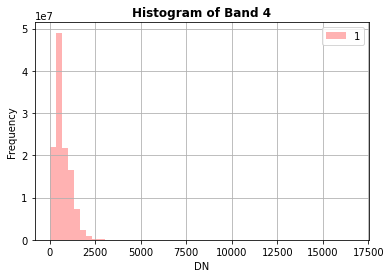

In [7]:
#plot histogram of band pixel values using RasterIO
show_hist(band4, bins=50, stacked=False, alpha=0.3, histtype='stepfilled', 
          title="Histogram of Band 4")

Now, let us plot a greyscale image of Band 4 on the screen.

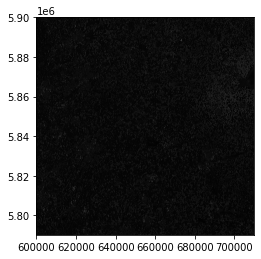

In [8]:
#plot band using RasterIO - Remember we did: from rasterio import plot
plot.show(band4, cmap='gray')

In case the contrast of the image is not very good, we may not be able to see the actual image. This can happen if a few extreme values are in the image. 
We need to apply an image enhancement by stretching the histogram of pixel values. This allows us to select the minimum and maximum values that are going to be shown as the darkest and brightest grey tones. We can try three different thresholds, taken from the histogram of the Band 4 above.

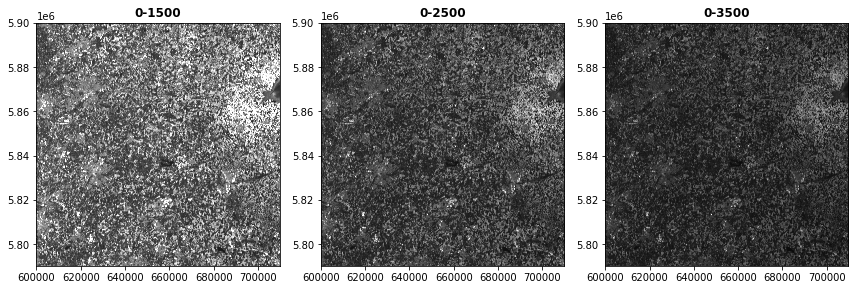

In [9]:
#plot the same image with different image enhancements (band stretching)
#plot images of multiple bands as separate subplots within the same figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
fig.patch.set_facecolor('white') # set a white background
plot.show(band4, ax=ax1, vmin=0, vmax=1500, cmap='gray', title="0-1500")
plot.show(band4, ax=ax2, vmin=0, vmax=2500, cmap='gray', title="0-2500")
plot.show(band4, ax=ax3, vmin=0, vmax=3500, cmap='gray', title="0-3500")
fig.tight_layout()

The three images above illustrate that the more extremely high pixel values we include in the display, the less contrast the image has (it appears darker and pattherns are harder to see).

What if we want to know the value of a particular pixel?

With the index function in RasterIO, we can easily find the row and column coordinate of a pixel if we know its geolocation in map coordinates. Say we want to know the pixel value that is 100km from the left side of the image and 50km from the top.

In [10]:
x, y = (band4.bounds.left + 100000, band4.bounds.top - 50000)
row, col = band4.index(x, y)
print("Row ", row, ", Column ", col, ": Pixel value = ", b4[row, col])

Row  5000 , Column  10000 : Pixel value =  578


So far, we have only looked at a single band - Band 4. We can also plot several different bands in different colours. Let's do that with the Blue, Green and Red reflectance bands, which are bands 2, 3 and 4.

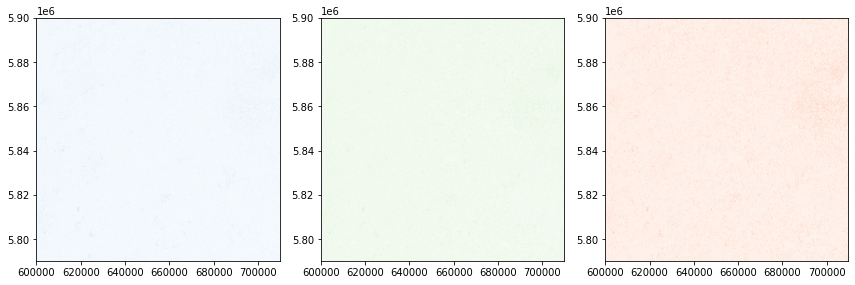

In [11]:
#plot images of multiple bands as separate subplots within the same figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
fig.patch.set_facecolor('white')
plot.show(band2, ax=ax1, cmap='Blues')
plot.show(band3, ax=ax2, cmap='Greens')
plot.show(band4, ax=ax3, cmap='Reds')
fig.tight_layout()

The maps do not look very good, perhaps. They may appear almost white with little contrast. This is because the bands often have extremely high reflectance values.
We can exclude these very high values from the colour stretching. To do this, let us cut off the 10% highest values of each band. The NumPy function percentile does that: We can calculate the 90% percentile. Above that value lie the 10% highest pixel values. Then we use that value in the colour stretching.

P98 of band 2 =  1035.0
P98 of band 3 =  1608.0
P98 of band 4 =  1849.0


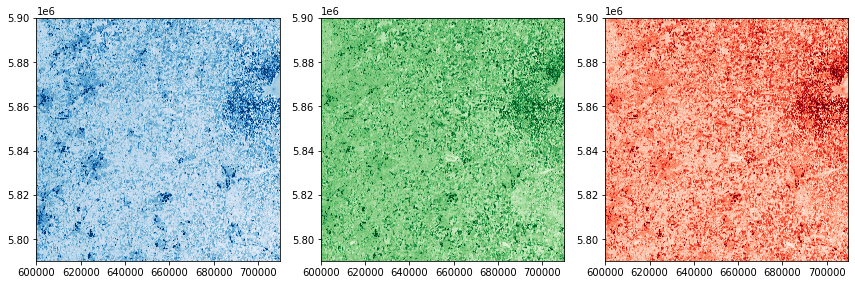

In [12]:
# calculate the 98% percentiles of the bands for visualisation (histogram enhancement)
v2=np.percentile(band2.read(1), 98)
v3=np.percentile(band3.read(1), 98)
v4=np.percentile(band4.read(1), 98)
print("P98 of band 2 = ", v2)
print("P98 of band 3 = ", v3)
print("P98 of band 4 = ", v4)

#plot images of multiple bands as separate subplots within the same figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
fig.patch.set_facecolor('white')
plot.show(band2, ax=ax1, vmin=0, vmax=v2, cmap='Blues')
plot.show(band3, ax=ax2, vmin=0, vmax=v3, cmap='Greens')
plot.show(band4, ax=ax3, vmin=0, vmax=v4, cmap='Reds')
fig.tight_layout()

Much better, isn't it?

We can replace all the values above a threshold, e.g. the 98% percentile or an arbitrary value, before we save the image as a true colour composite.
Here we set the threshold to 2000. This is the threshold that the European Space Agency uses to produces True Colour Composite quicklooks from all Sentinel-2 images.

In [13]:
# read in all the pixel values from the four bands into arrays
b2=band2.read(1)
b3=band3.read(1)
#b4=band4.read(1) # we had already read the data from band 4 into the array b4
b8=band8.read(1)

# we can also compute the 98% percentile for band 8
v8=np.percentile(b8, 98)
print("P98 of band 2 = ", v2)
print("P98 of band 3 = ", v3)
print("P98 of band 4 = ", v4)
print("P98 of band 8 = ", v8)

# Define a maximum pixel value to exclude extreme values
# We use 2000 because ESA use this in their processing 
# https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/definitions
ceiling = 2000

# find all pixel values above the 98% percentile and replace them with the value 2000
b2[b2 > v2] = ceiling
b3[b3 > v3] = ceiling
b4[b4 > v4] = ceiling
b8[b8 > v8] = ceiling

P98 of band 2 =  1035.0
P98 of band 3 =  1608.0
P98 of band 4 =  1849.0
P98 of band 8 =  5590.0


RasterIO allows us to save the three bands (which come as separate files in the Sentinel-2 data structure) in a single raster file. GeoTiff is a commonly used format that all GIS software packages can read in.

In [14]:
#export a true colour composite image as a Geotiff file
trueColour = rasterio.open('/content/drive/My Drive/practicals21-22/Sentinel-2_TrueColour.tiff',
                          'w', driver='Gtiff', width=band4.width, height=band4.height,
                          count=3, crs=band4.crs, transform=band4.transform, 
                          dtype=band4.dtypes[0])
trueColour.write(b4, 1) #display Red reflectance as red colour on screen
trueColour.write(b3, 2) #display Green reflectance as green colour on screen
trueColour.write(b2, 3) #display Blue reflectance as blue colour on screen
trueColour.close()

Let's look at the result.

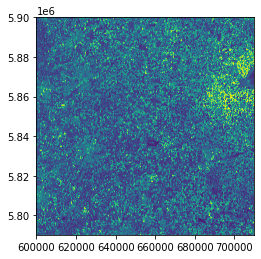

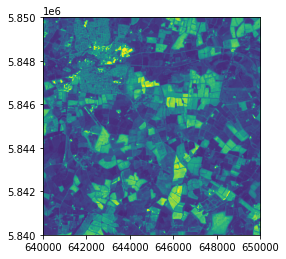

In [15]:
imgfile = rasterio.open(r'/content/drive/My Drive/practicals21-22/Sentinel-2_TrueColour.tiff', count=3)
plot.show(imgfile)

# zoom in to an area of interest
plt.xlim(640000,650000)
plt.ylim(5840000,5850000)
plot.show(imgfile)
imgfile.close()

While it is good to see that the image is represented visually, there is clearly a problem with the colour scheme. This a problem of the data format.

The RasterIO plotting documentation does not give a very clear clue as to why that may be - https://rasterio.readthedocs.io/en/latest/topics/plotting.html

We need to know that the RasterIO plot function uses Matplotlib - https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html 
The critical sentence here is that the image passed to pyplot.imshow must be of the form:

"(M, N, 3): an image with RGB values (0-1 float or 0-255 int)."
However, our Sentinel-2 image is a different data type. We looked at this when we first opened the raster band:
"type of raster byte: uint16"

uint16 is an unsigned integer data format in which each pixel value is represented as an unsigned (i.e. positive) number with 16 bits (2 bytes) of information. Unsigned integers can represent values between 0 and 65535.
https://numpy.org/doc/stable/user/basics.types.html
Floating point numbers have 64 bits per value and can represent numbers with digits behind the comma. Unsigned integers from 0-255 are called np.uint8 in NumPy, as one number is represented by only 8 bit (1 byte). This is the data format that is most efficient in terms of memory usage and storage space, but it stores a lot less information compared to 16 bit or even 32 or 64 bit data types.

Let's try to convert the uint16 data in our image into uint8 data type and rescale the values so that 0 represents the 2% percentile and 255 represents the 98% percentile of our image.


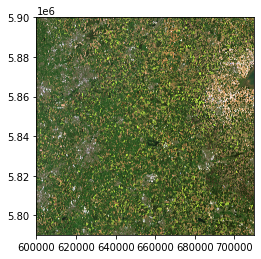

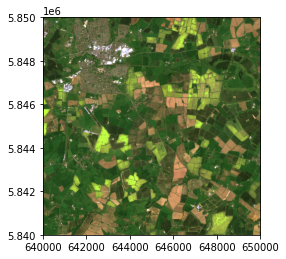

In [16]:
# Convert uint16 to unit8 and rescale to 0-255

# define a function that does it for us
def scale_to_uint8(a): 
  amin = a.min()
  amax = a.max()
  anewmin = 0.0
  anewmax = 255.0
  ascaled = (a - amin) * ((anewmax - anewmin) / (amax - amin)) + anewmin
  return(ascaled.astype(np.uint8))

# call our function and apply it to band 2
b2uint8 = scale_to_uint8(b2)

# band 3, 4 and 8
b3uint8 = scale_to_uint8(b3)
b4uint8 = scale_to_uint8(b4)
b8uint8 = scale_to_uint8(b8)

# We will be working with the uint8 images from here on, so we can
#   remove the arrays we do not use anymore from memory at this point.
b2 = None
b3 = None
b4 = None
b8 = None

# save the uint8 image as a Geotiff file
trueColour = rasterio.open('/content/drive/My Drive/practicals20-21/Sentinel-2_TrueColour_uint8.tiff',
                          'w',driver='Gtiff', width=band4.width, height=band4.height,
                          count=3, crs=band4.crs, transform=band4.transform, 
                          dtype=np.uint8)
trueColour.write(b2uint8, 3) #display Red reflectance as red colour on screen
trueColour.write(b3uint8, 2) #display Green reflectance as green colour on screen
trueColour.write(b4uint8, 1) #display Blue reflectance as blue colour on screen
trueColour.close()

# try plotting the image again
imgfile = rasterio.open(r'/content/drive/My Drive/practicals20-21/Sentinel-2_TrueColour_uint8.tiff', count=3)
plot.show(imgfile)

# zoom in to an area of interest
plt.xlim(640000,650000)
plt.ylim(5840000,5850000)
plot.show(imgfile)

imgfile.close()

Converting the pixel values to uint8 has fixed the problem.

RasterIO lets you make a histogram of multiple bands as well. In the pygge library, we have a wrapper function called 'hist_sample' which plots a histogram based only on a random sample of pixel values. This greatly speeds up the plotting.


bins = 20
lw = 0.0
figsize = (15, 5)
stacked = False
alpha = 0.3
histtype = stepfilled
title = Histogram
0
1
2


(<Figure size 1080x360 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f07b6d99510>,
       dtype=object))

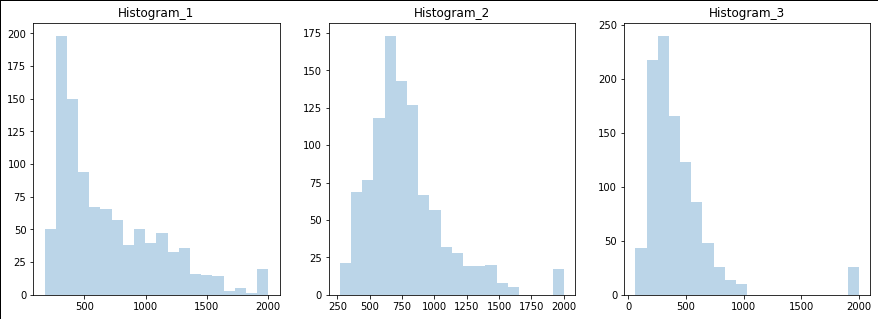

In [17]:
# set some keyword arguments for the histogram plot
kwargs = {
    "bins": 20, 
    "lw": 0.0, 
    "figsize": (15,5), # for 3 bands the figure should be 3 times wider than high
    "stacked": False, 
    "alpha": 0.3,
    "histtype": 'stepfilled', 
    "title": 'Histogram'
    }

# print the keyword arguments
for key, value in kwargs.items():
  print("{0} = {1}".format(key, value))

pygge.hist_sample('/content/drive/My Drive/practicals20-21/Sentinel-2_TrueColour.tiff',
                  n=1000, missing=65535, **kwargs)

0
1
2


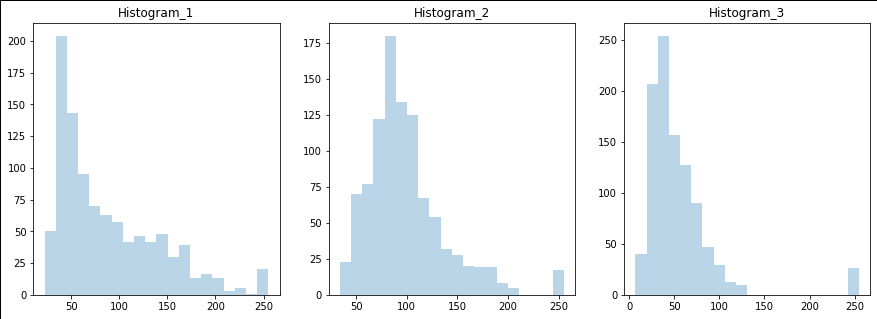

In [18]:
#and from the uint8 image
pygge.hist_sample('/content/drive/My Drive/practicals20-21/Sentinel-2_TrueColour_uint8.tiff',
                  n=1000, missing=65535, **kwargs)
trueColour.close()

You can see the difference in the range of values on the x axis between the uint16 and uint8 number format.

Another common way of visualising satellite images is as a False Colour Composite:

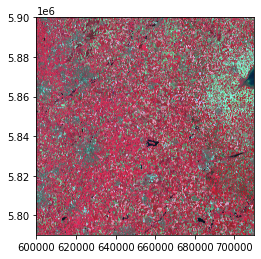

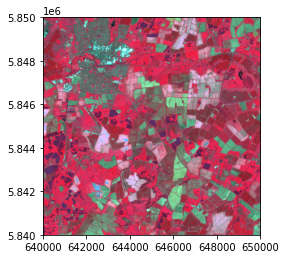

In [19]:
#export a false colour composite image
falseColour = rasterio.open('/content/drive/My Drive/practicals20-21/Sentinel-2_FalseColour_uint8.tiff',
                           'w', driver='Gtiff', width=band2.width, height=band2.height,
                           count=3, crs=band2.crs, transform=band2.transform,
                           dtype=np.uint8)
falseColour.write(b3uint8,3) # show Green reflectance as Blue colour on screen
falseColour.write(b4uint8,2) # show Red reflectance as Green colour on screen
falseColour.write(b8uint8,1) # show NIR reflectance as Red colour on screen
falseColour.close()

# plot the uint8 false colour composite image
imgfile = rasterio.open(r'/content/drive/My Drive/practicals20-21/Sentinel-2_FalseColour_uint8.tiff', count=3)
plot.show(imgfile)

# zoom in to an area of interest
plt.xlim(640000,650000)
plt.ylim(5840000,5850000)
plot.show(imgfile)

imgfile.close()

# And that is the end of this week's practical.